####  Time Series Analysis and Modeling with the Air Passengers Dataset
    * Analyze monthly totals of international airline passengers from 1949 to 1960.
    * ARMA/ARIMA models will be considered in this analysis.

In [2]:
import numpy as np
import pandas as pd
from datetime import datetime as dt

# acf, pacf - q , p value for ARIMA
from statsmodels.tsa.stattools import adfuller, acf, pacf
# ARIMA 
from statsmodels.tsa.arima_model import ARIMA
import math
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 15, 6

import warnings
warnings.filterwarnings('ignore')

In [3]:
data = pd.read_csv('E:/Data/AirPassengers.csv')

In [4]:
data.columns = ['Month','Passengers']
data.head()

,Month,Passengers
0,1949-01,112
1,1949-02,118
2,1949-03,132
3,1949-04,129
4,1949-05,121


In [5]:
data.dtypes

Month         object
Passengers     int64
dtype: object

In [6]:
data.describe()

,Passengers
count,144.000000
mean,280.298611
std,119.966317
min,104.000000
25%,180.000000
50%,265.500000
75%,360.500000
max,622.000000


In [7]:
data.shape

(144, 2)

#### Converting to DateTime Format

In [8]:
# Typecasting object data type to '%Y-%m-%d'
data['Month'] = pd.to_datetime(data['Month'], format='%Y-%m')

In [9]:
# set Month as new axis 
data = data.set_index('Month')
data.head()

,Passengers
Month,
1949-01-01,112
1949-02-01,118
1949-03-01,132
1949-04-01,129
1949-05-01,121


In [10]:
data.isnull().sum()

Passengers    0
dtype: int64

####  Time Series Plots

    * A visual observation of time series plots / histograms can give an insight into the presence of trend and seasonality in the data

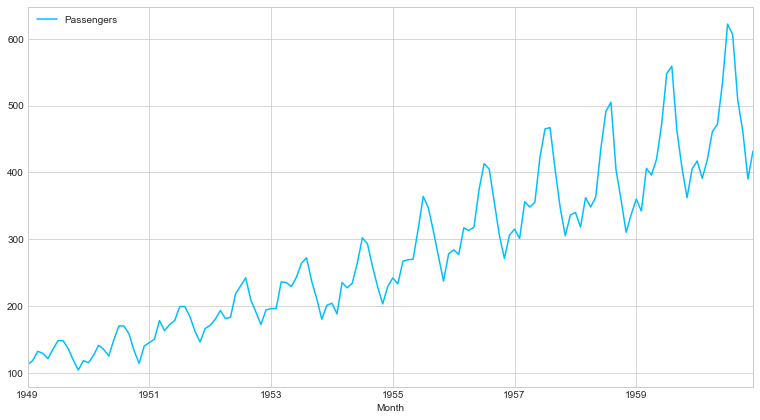

In [11]:
plt.style.use('seaborn-whitegrid')
data.plot(figsize = (13, 7), color = 'deepskyblue')
plt.show()

#### Reviewing plots of the density of observations can provide further insight into the structure of the data:
    * The distribution is not perfectly Gaussian (normal distribution).
    * The distribution is right shifted.
    * Transformations might be useful prior to modeling.

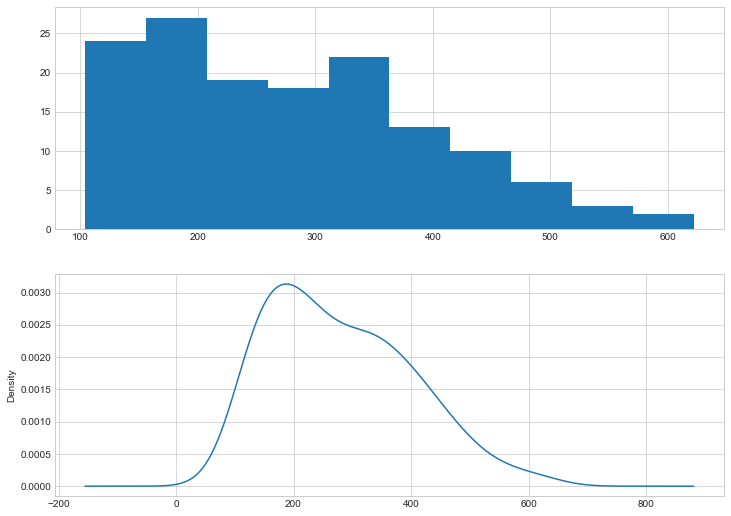

In [12]:
plt.figure(figsize = (12,9))
plt.subplot(211)
data.Passengers.hist()
plt.subplot(212)
data.Passengers.plot(kind = 'kde')
plt.show()

<AxesSubplot:xlabel='Month', ylabel='Passengers'>

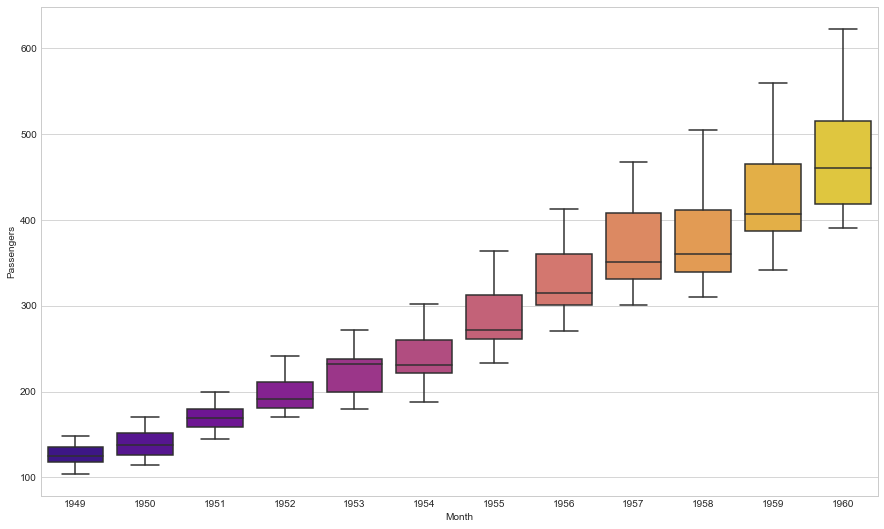

In [13]:
plt.figure(figsize = (15,9))
sns.boxplot(data.Passengers.index.year, data.Passengers, palette='plasma')

    * Median values across years confirms an upwards trend
    * Steady increase in the spread, or middle 50% of the data (boxes) over time
    * A model considering seasonality might work well

In [14]:
ts = data['Passengers']

#### Plotting Rolling Statistics
    * One can plot moving averages/variances to observe any changes in the average/variance over time.
    * The data can be partitioned into various subsets of different time intervals and summary statistics such as mean and variances can be observed over these time periods.

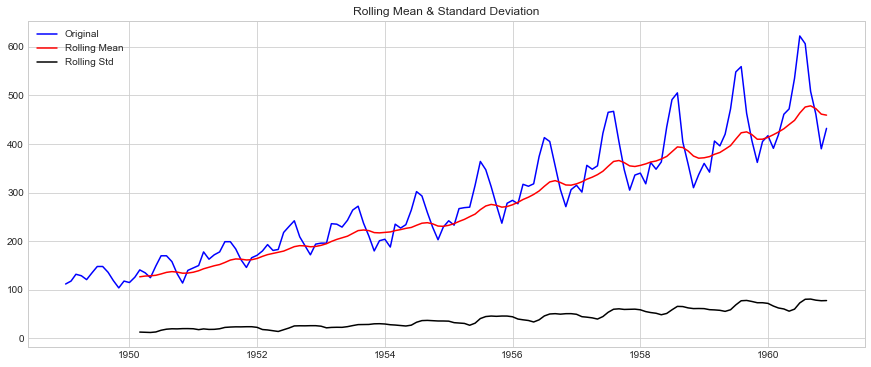

In [15]:
# Determining Rotting Statistics
rolmean = data.rolling(window=15).mean()
rolstd = data.rolling(window=15).std()

# Plot rolling statistics
orig = plt.plot(data, color = 'blue', label = 'Original')
mean = plt.plot(rolmean, color = 'red', label = 'Rolling Mean')
std = plt.plot(rolstd, color = 'black', label = 'Rolling Std')
plt.legend(loc='best')
plt.title('Rolling Mean & Standard Deviation')
plt.show(block=False)

    * We observe that the moving(rolling) mean and moving std dev are not constant with respect to time (both are showing increasing trends). Ideal case moving avg., moving std dev must be constant.
    * The time series is not stationary

#### Augmented Dickey- Fuller test

The intuition behind the test is that if the series is integrated then the lagged level of the series y(t-1) will provide no relevant information in predicting the change in y(t).

    * Null Hypothesis (H0) that the time series is not stationary and 
    * Alternate hypothesis (H1) that the time series is stationary. 

The test results comprise of a Test Statistic and some Critical Values for difference confidence levels. If the 'Test Statistic' is less than the 'Critical Value', we can reject the null hypothesis and say that the series is stationary.

In [16]:
from statsmodels.tsa.stattools import adfuller

print('Resilts of Dickey-Fuller Test:')
dftest = adfuller(data.Passengers, autolag='AIC')
dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
for key,value in dftest[4].items():
    dfoutput['Critical Value (%s)'%key] = value
print(dfoutput)

Resilts of Dickey-Fuller Test:
Test Statistic                   0.815369
p-value                          0.991880
#Lags Used                      13.000000
Number of Observations Used    130.000000
Critical Value (1%)             -3.481682
Critical Value (5%)             -2.884042
Critical Value (10%)            -2.578770
dtype: float64


    * We Failed to Reject null hypothesis, that the time series is not stationary at p value of 0.99.

#### Create a Function to Test Stationarity

In [17]:
# H0 - It is non stationary
# H1 - It is stationary (Alternative Hypothesis)
def test_stationarity(timeseries):
    
    #Determing rolling statistics
    rolmean = timeseries.rolling(window=12,center=False).mean() 
    rolstd = timeseries.rolling(window=12,center=False).std()

    #Plot rolling statistics:
    orig = plt.plot(timeseries, color='blue',label='Original')
    mean = plt.plot(rolmean, color='red', label='Rolling Mean')
    std = plt.plot(rolstd, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show(block=False)
    
    #Perform Dickey-Fuller test:
    print ('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print (dfoutput)

#### How to make a Time Series stationary?

Most of the real life datasets will exhibit non stationarity.

There are multiple ways to make a time series stationary:

- Transformation
    - Log transformation
    - square root transformation
    - Box cox transformation
    - Exponential transformation

- Differencing: Differencing is carried out to get rid of varying mean due to trend. In this difference in consecutive terms in the time series is computed. Mathematically it can be represented as :
                  yt = yt - y(t-1)
                  where yt is the value at time t.
    - Seasonal differencing: In case of presence of seasonality in the data, seasonal differencing can be carried out. In seasonal differencing, we calculate the difference between observation and previous observation of the same season. For example, an observation taken on a Monday is subtracted from that taken on previous Monday or that taken for week1 of a month is subtracted from week  of the previous month. Mathematically it can be represented as:
    
                   yt‘ = yt – y(t-n) 
                   where n is the season length
- Smoothing
- Decomposition

In [18]:
# Log scale transformation
ts_log = np.log(ts)

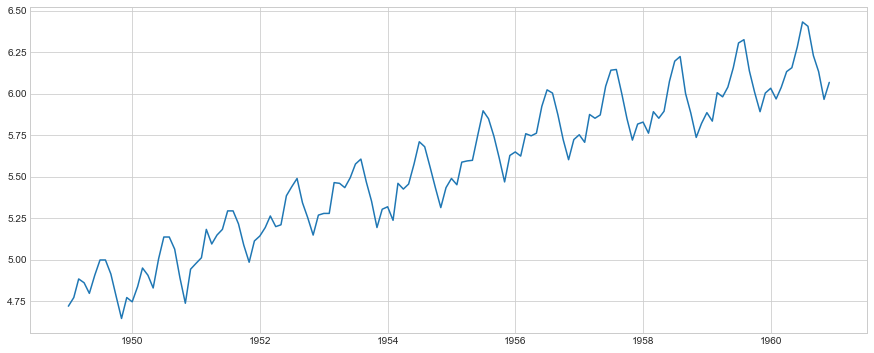

In [19]:
plt.plot(ts_log)

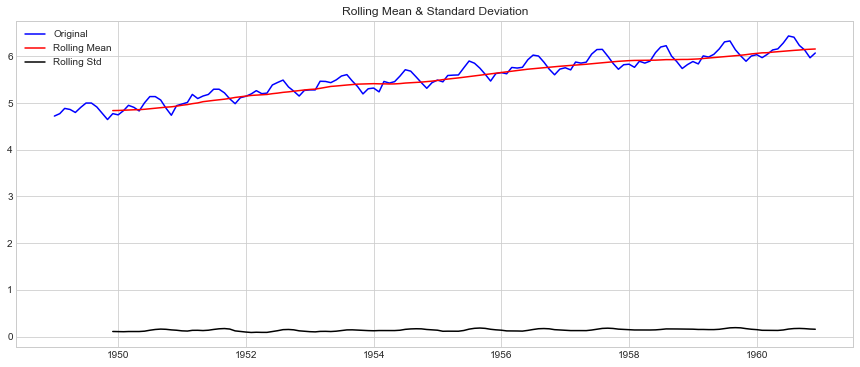

Results of Dickey-Fuller Test:
Test Statistic                  -1.717017
p-value                          0.422367
#Lags Used                      13.000000
Number of Observations Used    130.000000
Critical Value (1%)             -3.481682
Critical Value (5%)             -2.884042
Critical Value (10%)            -2.578770
dtype: float64


In [20]:
test_stationarity(ts_log)

    * Since p value is 0.42 which is greater than 0.05, also rolling mean is not constant hence the log scale transformation is not making the series stationary. 

#### Differencing
    * In this technique, we take the difference of the observation at a perticular instant with that at the previous instant.

In [21]:
ts_diff = ts - ts.shift(1)
ts_diff

Month
1949-01-01     NaN
1949-02-01     6.0
1949-03-01    14.0
1949-04-01    -3.0
1949-05-01    -8.0
              ... 
1960-08-01   -16.0
1960-09-01   -98.0
1960-10-01   -47.0
1960-11-01   -71.0
1960-12-01    42.0
Name: Passengers, Length: 144, dtype: float64

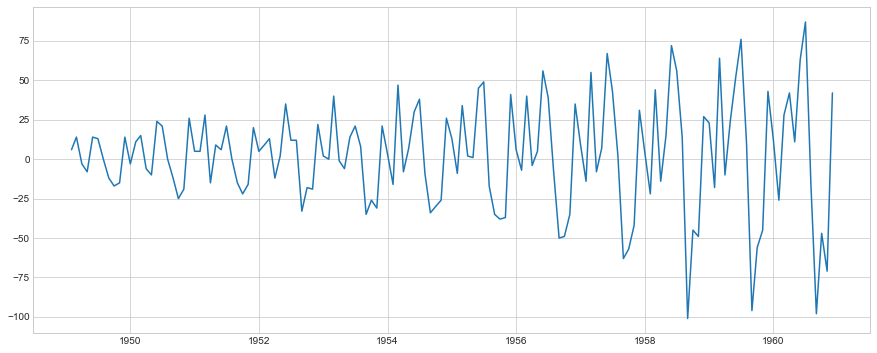

In [22]:
plt.plot(ts_diff)

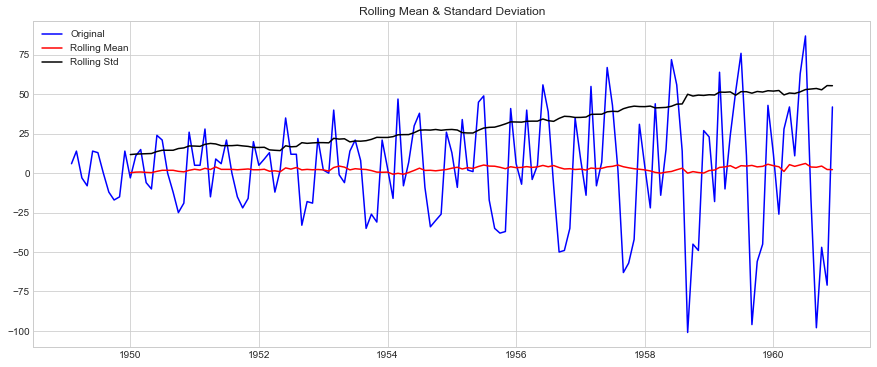

Results of Dickey-Fuller Test:
Test Statistic                  -2.829267
p-value                          0.054213
#Lags Used                      12.000000
Number of Observations Used    130.000000
Critical Value (1%)             -3.481682
Critical Value (5%)             -2.884042
Critical Value (10%)            -2.578770
dtype: float64


In [23]:
ts_diff.dropna(inplace=True)
test_stationarity(ts_diff)

#### Log Differencing

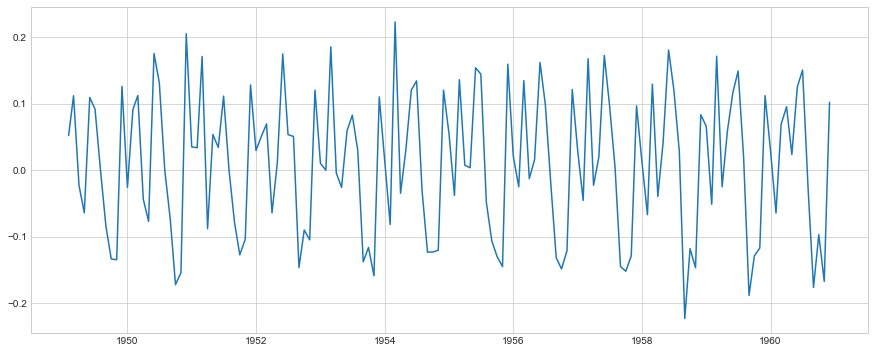

In [24]:
# differencing (d) is by 1 value shift
ts_log_diff = ts_log - ts_log.shift(1)
plt.plot(ts_log_diff)

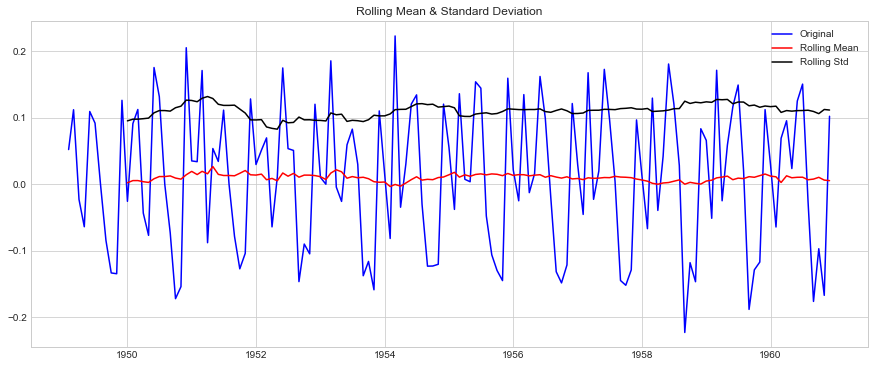

Results of Dickey-Fuller Test:
Test Statistic                  -2.717131
p-value                          0.071121
#Lags Used                      14.000000
Number of Observations Used    128.000000
Critical Value (1%)             -3.482501
Critical Value (5%)             -2.884398
Critical Value (10%)            -2.578960
dtype: float64


In [25]:
ts_log_diff.dropna(inplace=True)
test_stationarity(ts_log_diff)

        * At p value closer to 0.05, and moving mean & moving std is also constant hence, alternative hypothesis is accepted. The series is stationary.

#### Get the difference between moving average and the actual number of passengers.

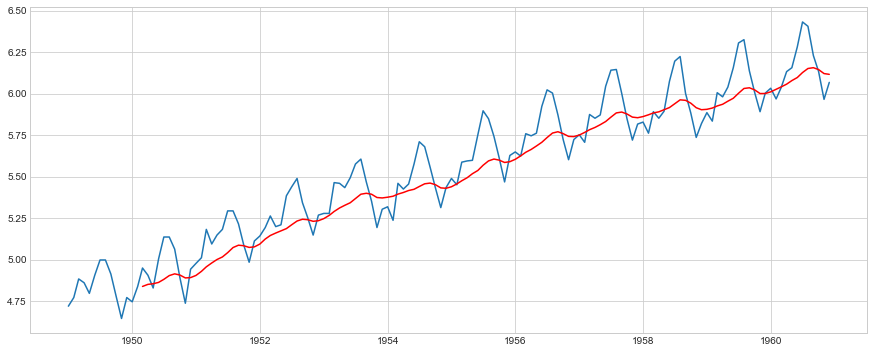

In [26]:
movingAverage = ts_log.rolling(window=15).mean()
movingSTD = ts_log.rolling(window=15).std()
plt.plot(ts_log)
plt.plot(movingAverage, color = 'red')

In [27]:
# Get the difference between the moving average and the actual number of passengers
ts_log_mv_diff = ts_log - movingAverage
ts_log_mv_diff.head(12)
#Remove Nan Values
ts_log_mv_diff.dropna(inplace=True)
ts_log_mv_diff.head(10)

Month
1950-03-01    0.111152
1950-04-01    0.055215
1950-05-01   -0.025588
1950-06-01    0.141969
1950-07-01    0.255422
1950-08-01    0.232755
1950-09-01    0.149063
1950-10-01   -0.016059
1950-11-01   -0.152808
1950-12-01    0.050703
Name: Passengers, dtype: float64

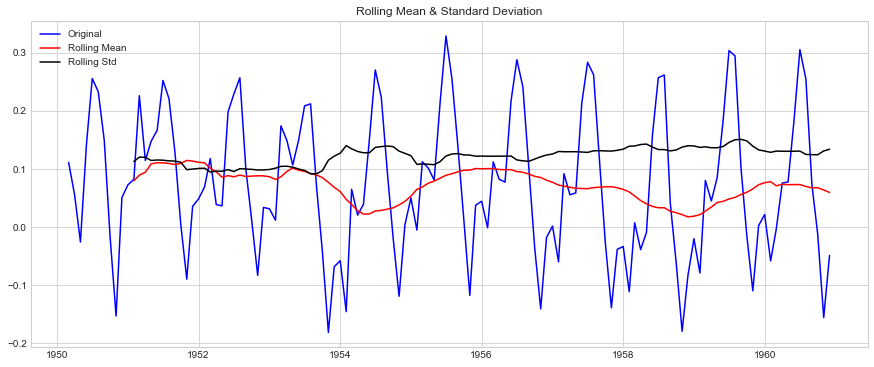

Results of Dickey-Fuller Test:
Test Statistic                  -3.079301
p-value                          0.028123
#Lags Used                      13.000000
Number of Observations Used    116.000000
Critical Value (1%)             -3.488022
Critical Value (5%)             -2.886797
Critical Value (10%)            -2.580241
dtype: float64


In [28]:
test_stationarity(ts_log_mv_diff)

    * The time series is now stationary.

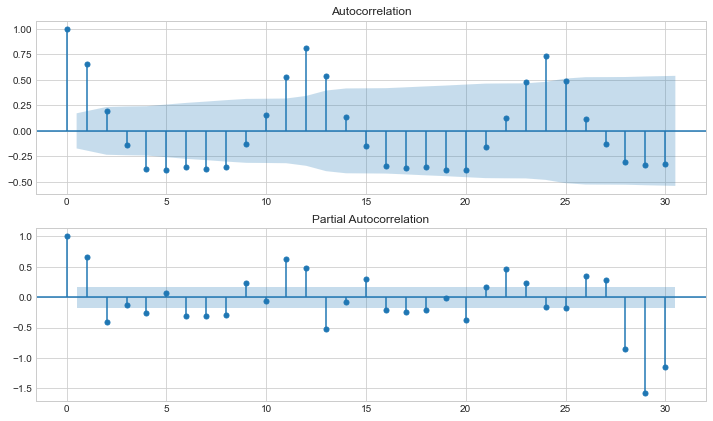

In [29]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

plt.figure(figsize = (12,7))
plt.subplot(211)
plot_acf(ts_log_mv_diff, ax=plt.gca(),lags=30)
plt.subplot(212)
plot_pacf(ts_log_mv_diff, ax=plt.gca(),lags=30)
plt.show()

* The ACF curve crosses the upper confidence value when the lag value is between 0 and 1. Thus, optimal value of q in the ARIMA model must be 0 or 1
* The PACF curve drops to 0 between lag values 1 and 2. Thus, optimal value of p in the ARIMA model is 1 or 2.

In [30]:
model = ARIMA(ts_log, order = (2,1,1))
results_ARIMA = model.fit(disp = 1) 

Text(0.5, 1.0, 'RMSE: 0.5438')

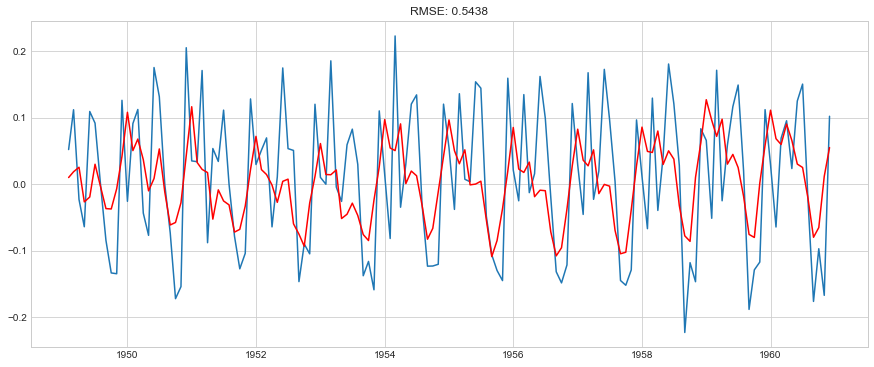

In [31]:
plt.plot(ts_log_diff)
plt.plot(results_ARIMA.fittedvalues, color='red')
plt.title('RMSE: %.4f'% sum(results_ARIMA.fittedvalues - ts_log_diff)**2)

Text(0.5, 1.0, 'RMSE: 0.0000')

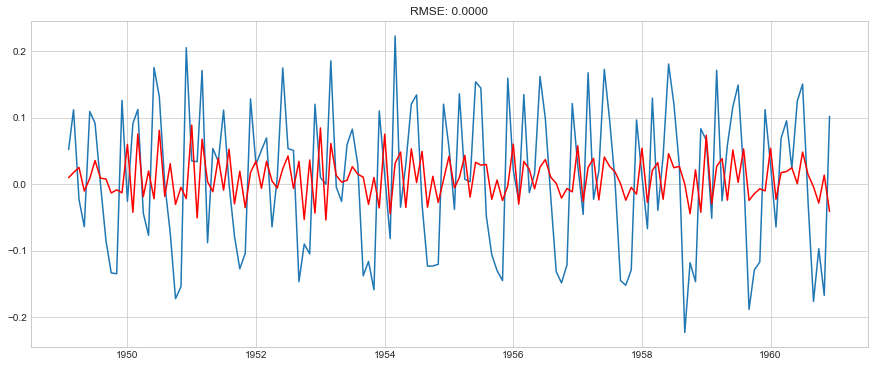

In [32]:
model = ARIMA(ts_log, order = (1,1,1))
results_ARIMA_final = model.fit(disp=1)
plt.plot(ts_log_diff)
plt.plot(results_ARIMA_final.fittedvalues, color='red')
plt.title('RMSE: %.4f'% sum(results_ARIMA_final.fittedvalues - ts_log_diff)**2)

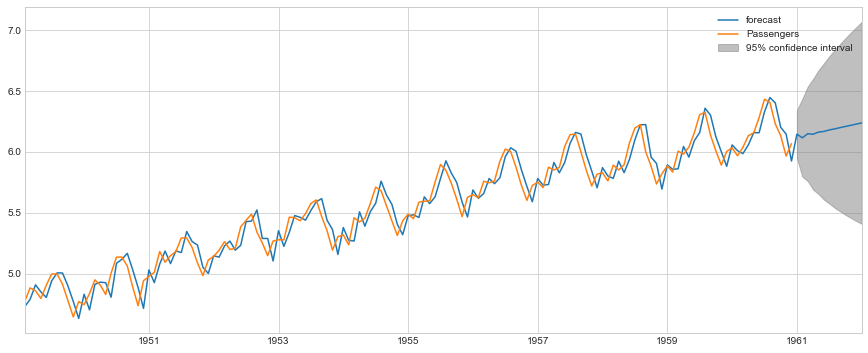

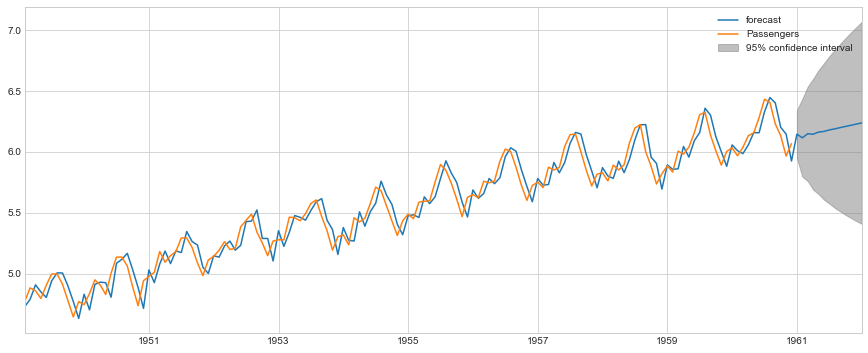

In [38]:
results_ARIMA_final.plot_predict(1, 156)